In [1]:
# import BERT tokenization

!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [2]:
import os
import re
import pickle
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [3]:
data_1 = pd.read_json("/kaggle/input/sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
data_2 = pd.read_json("/kaggle/input/sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json", lines=True)
df =  pd.concat([data_1, data_2])
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df = df.sample(frac = 1)
df.head()

,article_link,headline,is_sarcastic
19411,https://www.huffingtonpost.com/entry/scary-lan...,airplane's terrifying landing may put you off ...,0
4341,https://local.theonion.com/teary-eyed-student-...,teary-eyed student loan officers proudly watch...,1
24164,https://entertainment.theonion.com/meg-white-d...,meg white drum solo maintains steady beat for ...,1
3075,https://www.huffingtonpost.com/entry/eric-garn...,thousands march in nyc to protest chokehold death,0
12950,https://local.theonion.com/secretary-cracks-un...,secretary cracks under administration of third...,1


In [5]:
print(len(df))
split_length=int(0.7 *len(df))  
print(split_length)

55328
38729


In [6]:
pip install tokenization

Note: you may need to restart the kernel to use updated packages.


In [7]:
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
# from sklearn.model_selection import train_test_split

In [8]:
train_data = df[:-split_length]
test_data = df[-split_length:]

In [9]:
train_data.head()

,article_link,headline,is_sarcastic
19411,https://www.huffingtonpost.com/entry/scary-lan...,airplane's terrifying landing may put you off ...,0
4341,https://local.theonion.com/teary-eyed-student-...,teary-eyed student loan officers proudly watch...,1
24164,https://entertainment.theonion.com/meg-white-d...,meg white drum solo maintains steady beat for ...,1
3075,https://www.huffingtonpost.com/entry/eric-garn...,thousands march in nyc to protest chokehold death,0
12950,https://local.theonion.com/secretary-cracks-un...,secretary cracks under administration of third...,1


In [10]:
test_data.head()

,article_link,headline,is_sarcastic
18487,https://local.theonion.com/whos-this-little-gu...,who's this little guy?,1
21479,https://www.huffingtonpost.com/entry/baltimore...,"thousands protest peacefully in baltimore, and...",0
22860,https://www.huffingtonpost.com/entry/bernie-sa...,why bernie sanders is in deep trouble in south...,0
4200,https://local.theonion.com/uptight-matron-enjo...,uptight matron enjoys handful of pills,1
7400,https://www.theonion.com/nypd-offering-no-ques...,nypd offering no-questions-asked dvd drop-off,1


**Label encoding of labels**

In [11]:
# label = preprocessing.LabelEncoder()
# y = label.fit_transform(train_data['is_sarcastic'])
# y = to_categorical(y)
# print(y[:5])
y = train_data['is_sarcastic']
print(y[:5])


19411    0
4341     1
24164    1
3075     0
12950    1
Name: is_sarcastic, dtype: int64


**Build a BERT layer**

we create a BERT embedding layer by importing the BERT model from hub.KerasLayer

In [12]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

2022-12-31 23:37:17.831954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:37:17.832971: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:37:18.125160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:37:18.126092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-31 23:37:18.126900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

**Encoding the text**

we create a BERT vocab_file in the form a numpy array. We then set the text to lowercase and finally we pass our vocab_file and do_lower_case variables to the Tokenizer object.

In [13]:
# pip uninstall bert-for-tf2

In [14]:
pip install bert-for-tf2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=77ad5dfcbe8de3b73af857a033af0d462bfe9d65728e36e46841354065940d37
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=b5979f85dd6bfb77c429e420c4fa5d6ed4d72b2192b5bf442a191b6af5a0ff11
  Stored in directory: /root/.cache/pip/wheels/0e/fc/d2/a44fff33af0f233d7def6e7de413006d57c10e10ad736fe8f5
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=464e383578fad879b4d21c7e27624448d11417967abdf5bd2c4975ed42b379e0
  Stored in directory: /root/.cache/pip/wheels/e1/11/67/33cc51bbee127cb8fb2ba549cd29109b2f22

In [15]:
from bert import bert_tokenization

In [16]:
tokenizer = bert_tokenization.FullTokenizer(
        vocab_file= bert_layer.resolved_object.vocab_file.asset_path.numpy(), 
        do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()
    )


In [17]:

# vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
# do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [18]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(32, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

Here We check only the first 250 characters of each text, and also we set train-test input and train labels

In [19]:
max_len = 250
train_input = bert_encode(train_data.headline.values, tokenizer, max_len=max_len)
test_input = bert_encode(test_data.headline.values, tokenizer, max_len=max_len)
train_labels = y

In [20]:
# labels = label.classes_
# print(labels)

In [21]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


**Run the model**

In [22]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=6,
    callbacks=[checkpoint, earlystopping],
    batch_size=16,
    verbose=1
)

2022-12-31 23:38:01.883182: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
830/830 [==============================] - 771s 910ms/step - loss: 0.3136 - accuracy: 0.8699 - val_loss: 0.1970 - val_accuracy: 0.9214

Epoch 00001: val_accuracy improved from -inf to 0.92139, saving model to model.h5
Epoch 2/6
830/830 [==============================] - 760s 915ms/step - loss: 0.1288 - accuracy: 0.9543 - val_loss: 0.1902 - val_accuracy: 0.9265

Epoch 00002: val_accuracy improved from 0.92139 to 0.92651, saving model to model.h5
Epoch 3/6
830/830 [==============================] - 759s 915ms/step - loss: 0.0577 - accuracy: 0.9791 - val_loss: 0.3064 - val_accuracy: 0.9235

Epoch 00003: val_accuracy did not improve from 0.92651
Epoch 4/6
830/830 [==============================] - 759s 915ms/step - loss: 0.0302 - accuracy: 0.9908 - val_loss: 0.4082 - val_accuracy: 0.9229

Epoch 00004: val_accuracy did not improve from 0.92651
Epoch 5/6
830/830 [==============================] - 760s 915ms/step - loss: 0.0236 - accuracy: 0.9924 - val_loss: 0.2371 - val_accuracy: 0

In [23]:
test_pred = model.predict(test_input,verbose = 1)

1211/1211 [==============================] - 709s 585ms/step


In [24]:
y_pred=test_pred.round().astype(int)
y_pred

array([[1],
       [0],
       [0],
       ...,
       [0],
       [1],
       [1]])

In [25]:
submission = pd.DataFrame(y_pred, columns=['target'])

In [26]:
submission.to_csv('submission.csv', index=False)
submission.head()

,target
0,1
1,0
2,0
3,1
4,1


In [27]:
y_test = test_data['is_sarcastic']
print(y_test[:5])

18487    1
21479    0
22860    0
4200     1
7400     1
Name: is_sarcastic, dtype: int64


In [28]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.9280126003769785

In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94     21049
           1       0.96      0.88      0.92     17680

    accuracy                           0.93     38729
   macro avg       0.93      0.92      0.93     38729
weighted avg       0.93      0.93      0.93     38729



In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[20424,   625],
       [ 2163, 15517]])

Text(42.0, 0.5, 'Truth')

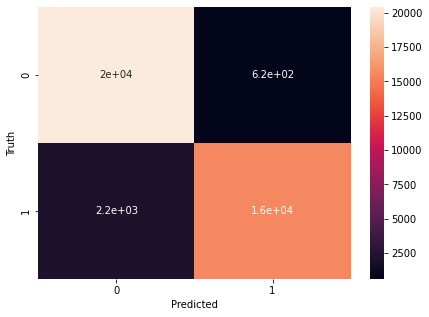

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
plt.figure(figsize=(7,5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')